<a href="https://colab.research.google.com/github/bug-vt/openCV_junior/blob/master/ECE4554_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change the directory to your own working directory
# Any files under your working directory are available to your code
import os
os.chdir('/content/drive/MyDrive/ECE5554_Fall2021/FinalProject')

In [3]:
# Import library modules
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # PIL is the Python Imaging Library
from google.colab.patches import cv2_imshow #(We cannot use cv2.imshow on Colab)

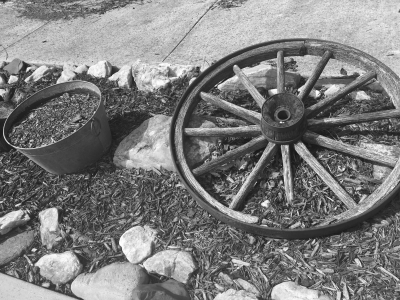

In [4]:
# Test loading image from google drive
img_color = cv2.imread("wheel.png", cv2.IMREAD_COLOR)
img_grayscale = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
cv2_imshow(img_grayscale)

## SIFT Detector

### 1. The scale space

In [5]:
def linear_filter(img_in, kernel):
  '''Filter an input image by applying cross-correlation with a kernel.

  Input: 
    img_in: a grayscale image of any size larger than the kernel
    kernel: a 2D array of floating-point values;
     you may assume that this array is square, 
     with an odd number of rows and an odd number of columns;
     use the *center* of this kernel as its point of reference for filtering.

  Output:
    img_out: an image with the same row/column size as img_in, 
     but each pixel is a floating-point value;
     apply the kernel only at locations where it fits entirely within the 
     input image; 
     the remaining pixels (near the outside border of the output image)
     must be set to zero;
     for any negative values, take the absolute value;
     clip the final output so that every pixel value lies in the range 0 to 255.

  '''
  flipped_kernel = np.flip(np.flip(kernel, 0), 1)
  padding = kernel.shape[0] // 2
  img_copy = np.pad(np.copy(img_in), padding)
  img_out = np.zeros((img_copy.shape[0], img_copy.shape[1]), dtype=np.float32) 

  # perform cross-correlation between padded img and flipped kernel
  for row in range(padding, img_copy.shape[0] - padding):
    for col in range(padding, img_copy.shape[1] - padding):
      sample = img_copy[row-padding:row+padding+1, col-padding:col+padding+1]
      img_out[row][col] = np.sum(np.multiply(sample, flipped_kernel))

      # making pixel value range between 0 to 255
      if img_out[row][col] < 0:
        img_out[row][col] = abs(img_out[row][col])
      if img_out[row][col] > 255:
        img_out[row][col] = 255
      
  
  # remove the artifact from padding and return output img
  return img_out[padding:img_out.shape[0] - padding,
                 padding:img_out.shape[1] - padding] 
                 # Each pixel must be of type np.float32

In [6]:
def gaussian(x, y, sigma):
  return np.exp(-(x**2 + y**2) / (2 * sigma**2)) / (2 * np.pi * sigma**2)

def gaussianKernel(sigma, size = 9):
  mid = size // 2
  kernel = [[gaussian(col - mid, row - mid, sigma) for col in range(size)] 
            for row in range(size)]
  kernel /= np.sum(kernel) # normalize
  return np.array(kernel, dtype=np.float32)

Original image:


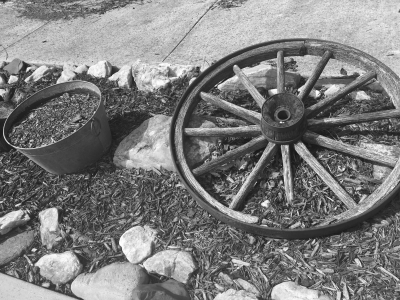


Down sampled image:


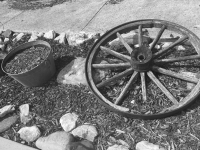

In [7]:
def getAvg(array, filter):
  return np.sum(array * filter)

def getFilter(size):
  filter = np.array([[1/size**2 for i in range(size)] for j in range(size)])
  return filter

def sub_sample(img_in):
  merge = 2
  filter = getFilter(merge)
  height = img_in.shape[0] // 2
  width = img_in.shape[1] // 2
  
  img_out = np.zeros((height, width))
    
  for y in range(0, img_in.shape[0], merge):
    for x in range(0, img_in.shape[1], merge):
      if y // 2 >= height or x // 2 >= width:
        continue
      sample = img_in[y:y+merge, x:x+merge]
      img_out[y // 2, x // 2] = getAvg(sample, filter)
      #img_out[y // 2, x // 2] = img_in[y, x]
  
  return img_out;

def test_sub_sample():
  print("Original image:")
  cv2_imshow(img_grayscale)
  print("\nDown sampled image:")
  lower_resolution = sub_sample(img_grayscale)
  cv2_imshow(lower_resolution)

test_sub_sample()

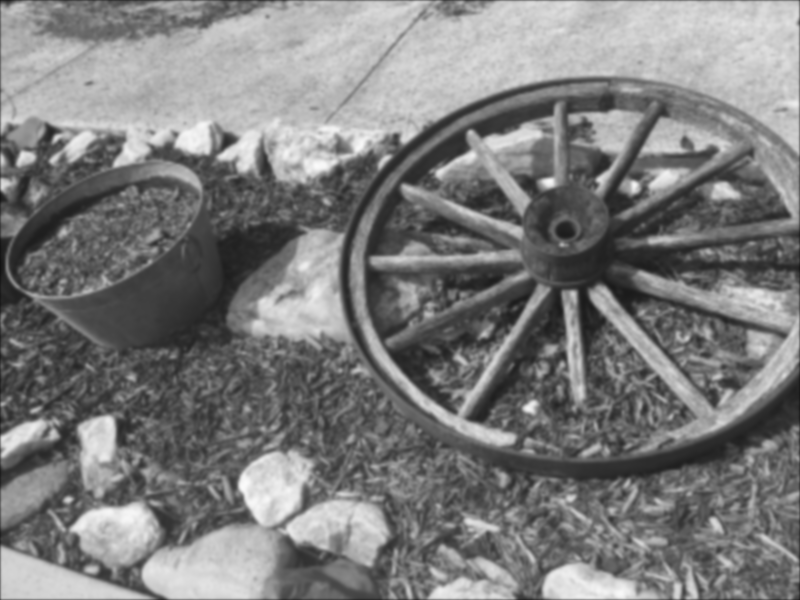

In [8]:
ASSUMED_BLURRED = 0.5
def sift_base_image(img_in, sigma, assumed_blurred):
  img_in = cv2.resize(img_in, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
  sigma_diff = np.sqrt(sigma**2 - (2 * assumed_blurred)**2)

  return linear_filter(img_in, gaussianKernel(sigma_diff))


def test_sift_base_image():
  base = sift_base_image(img_grayscale, 1.6, ASSUMED_BLURRED)
  cv2_imshow(base)

test_sift_base_image()

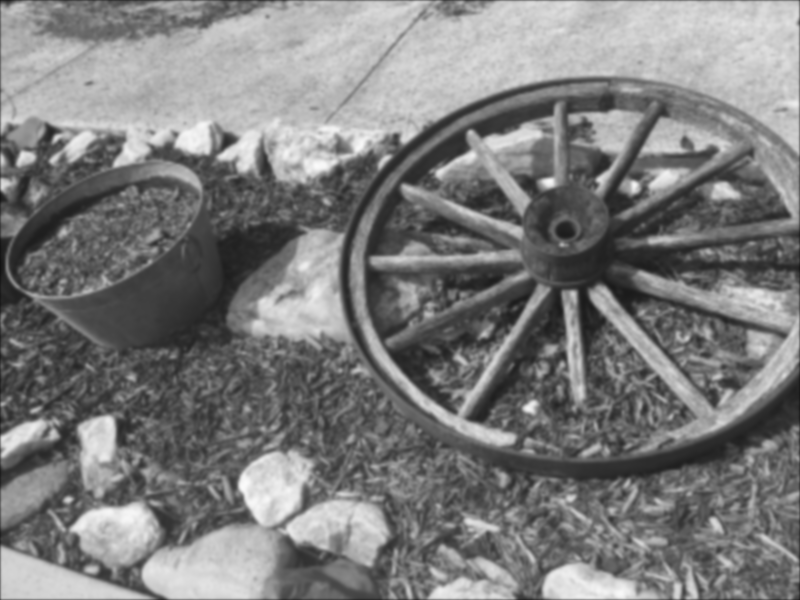

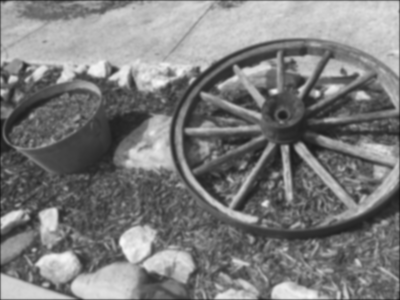

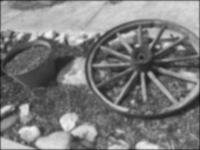

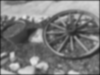

In [9]:
def gaussian_pyramid(img_in, sigma, octave):
  pyramid = [sift_base_image(img_in, sigma, ASSUMED_BLURRED)]
  for i in range(octave - 1):
    blurred = linear_filter(pyramid[i], gaussianKernel(sigma))
    pyramid.append(sub_sample(blurred))

  return pyramid

def test_gaussian_pyramid():
  pyramid = gaussian_pyramid(img_grayscale, 1.6, 4)
  for img in pyramid:
    cv2_imshow(img)
  return pyramid

g_pyramid = test_gaussian_pyramid()

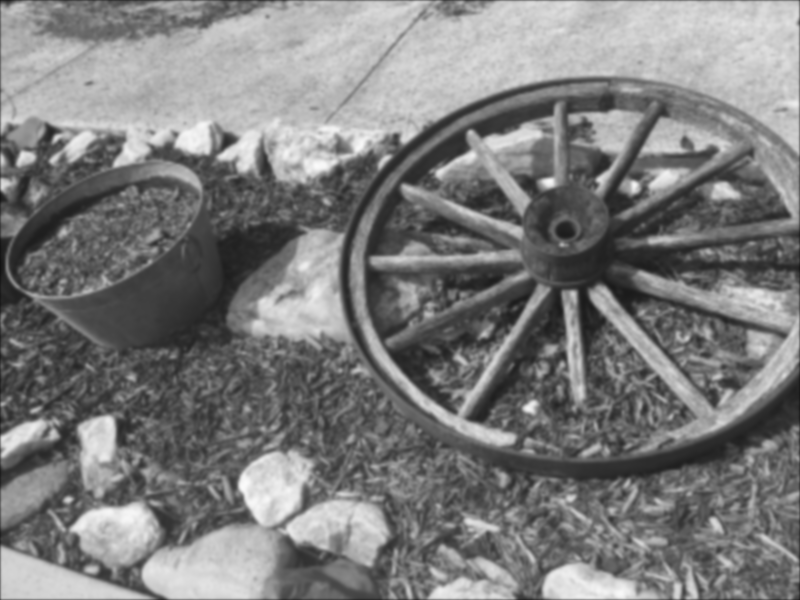

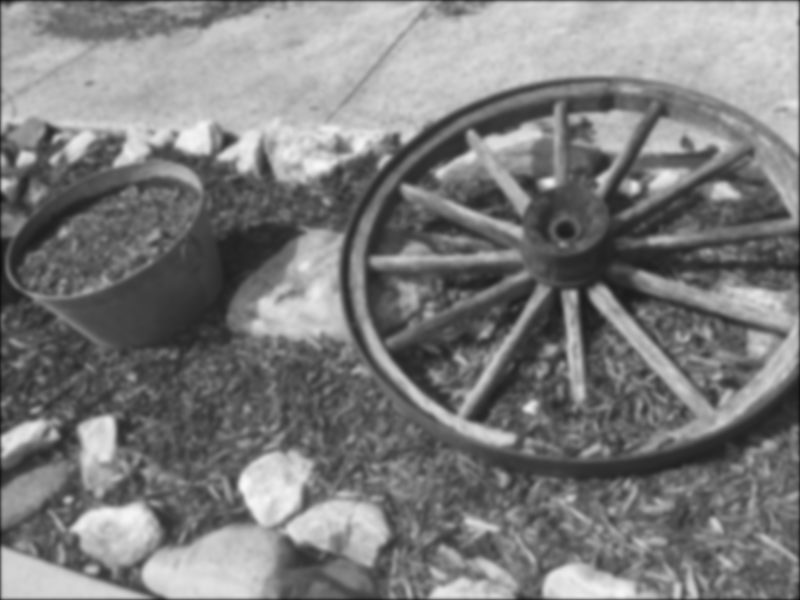

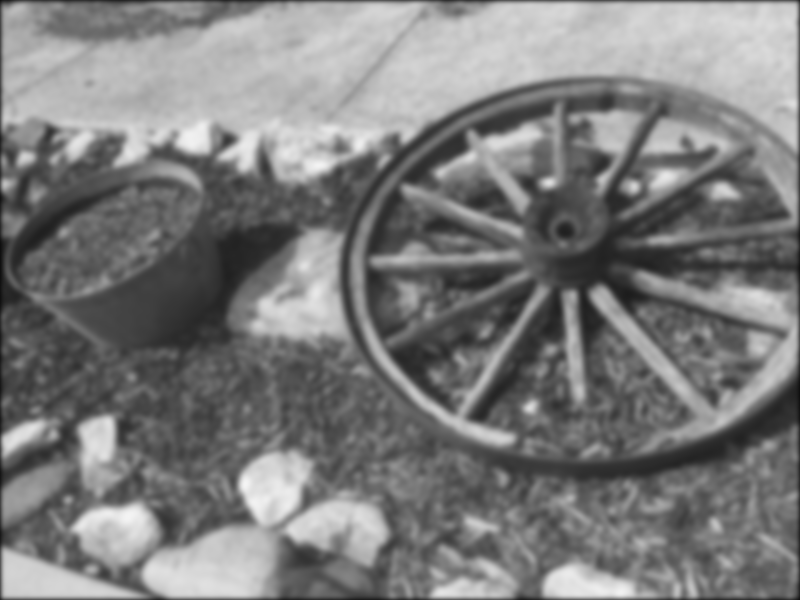

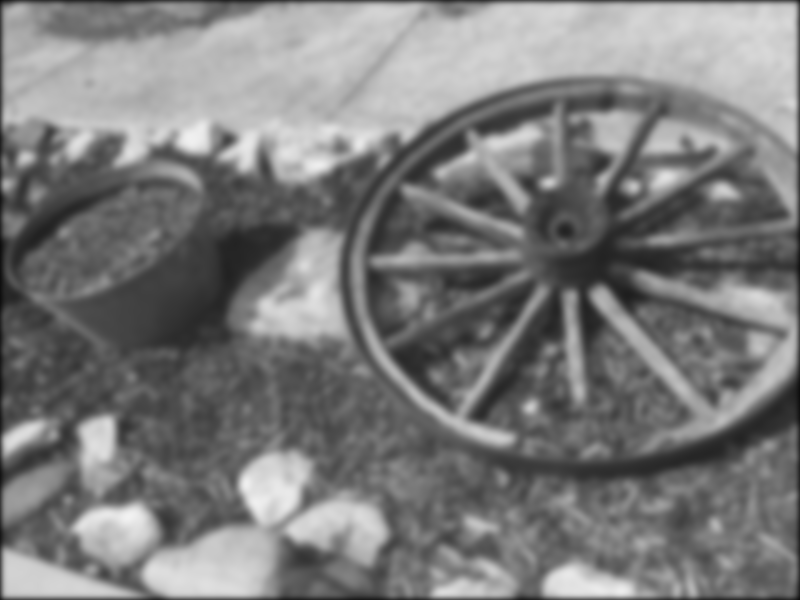

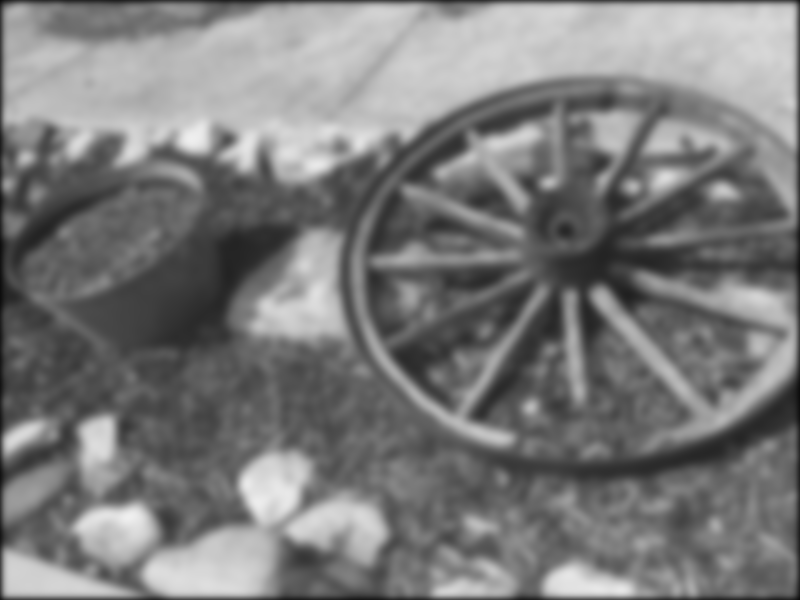

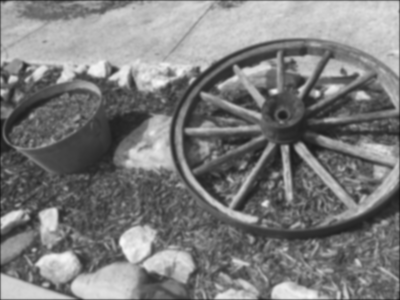

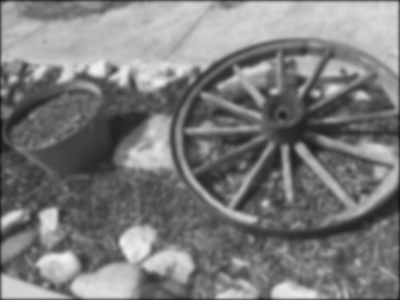

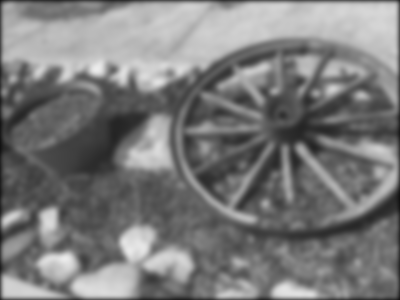

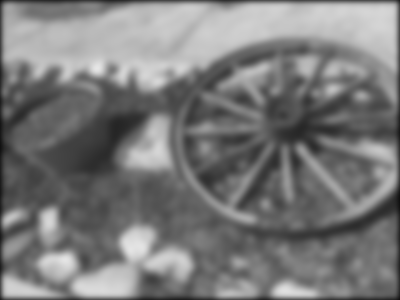

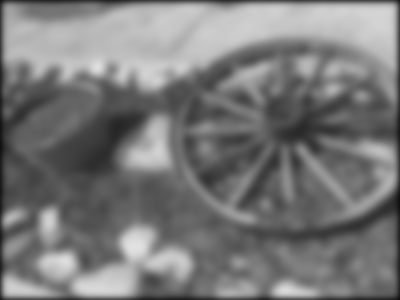

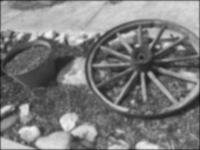

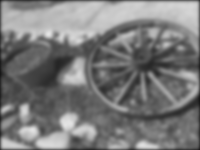

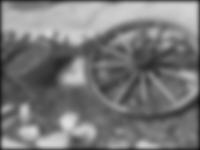

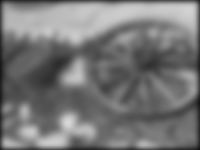

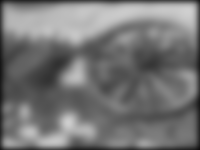

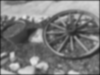

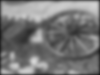

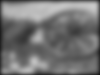

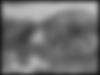

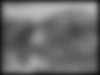

In [10]:
def sift_scale_space(img_in, sigma, octave, level, k, pyramid_in=None):
  if pyramid_in != None:
    pyramid = pyramid_in
  else:
    pyramid = gaussian_pyramid(img_in, sigma, octave)
  scale_space = []
  for img in pyramid:
    img_stack = [img]
    for i in range(1, level):
      sigma_prev = sigma * (k ** (i - 1))
      sigma_curr = sigma_prev * k
      sigma_diff = np.sqrt(sigma_curr**2 - sigma_prev**2)
      img_stack.append(linear_filter(img_stack[-1], gaussianKernel(sigma_diff)))
      
    #img_stack = [linear_filter(img, gaussianKernel(sigma)) for i in range(level - 1)]
    #img_stack.insert(0, img)
    scale_space.append(img_stack)

  return scale_space

def test_sift_scale_space():
  scale_space = sift_scale_space(img_grayscale, 1.6, 4, 5, np.sqrt(2), pyramid_in = g_pyramid)
  for img_stack in scale_space:
    for img in img_stack:
      cv2_imshow(img)
  return scale_space

s_scale_space = test_sift_scale_space()

### 2. LoG approximations

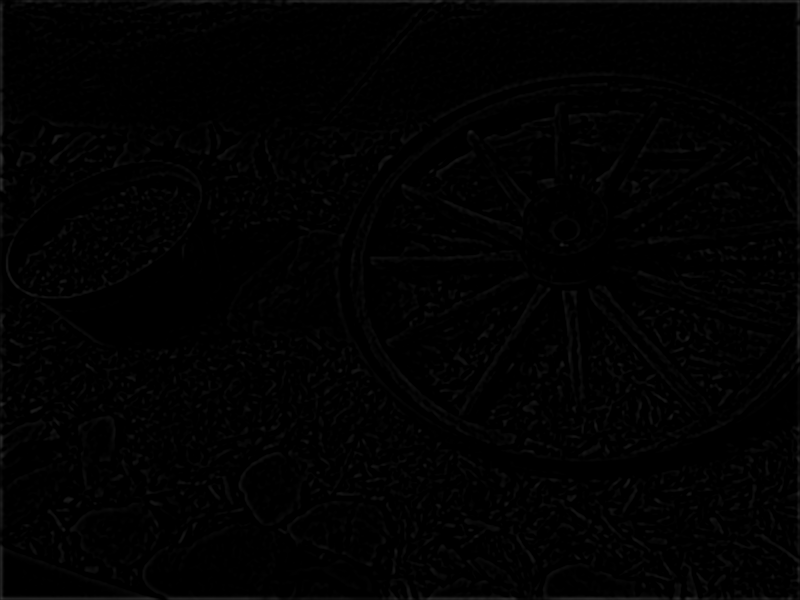

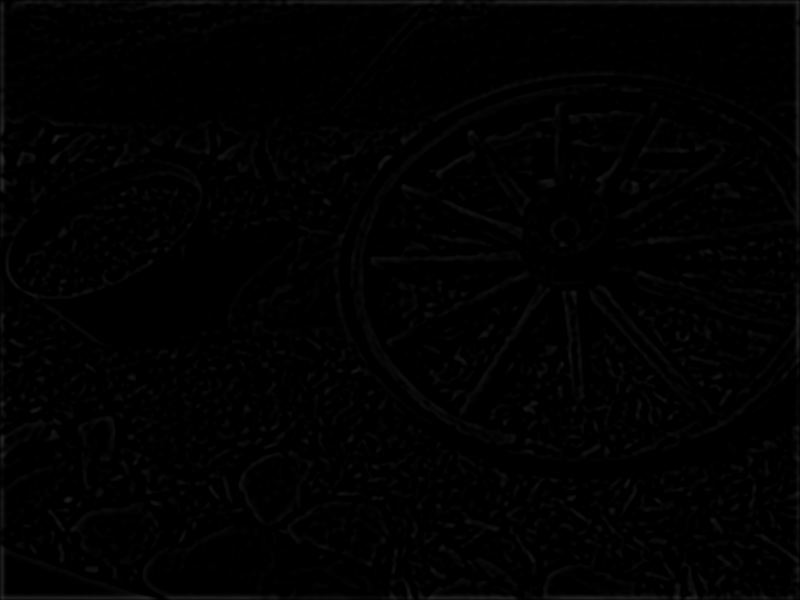

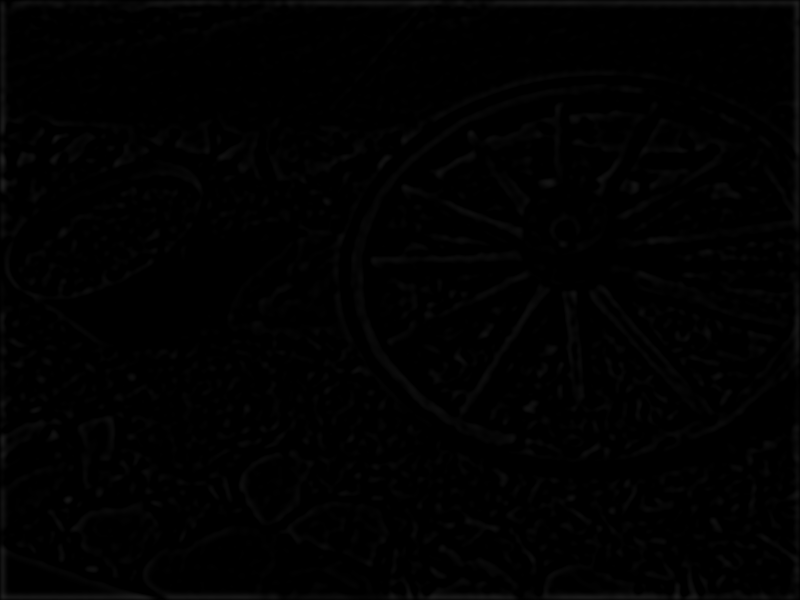

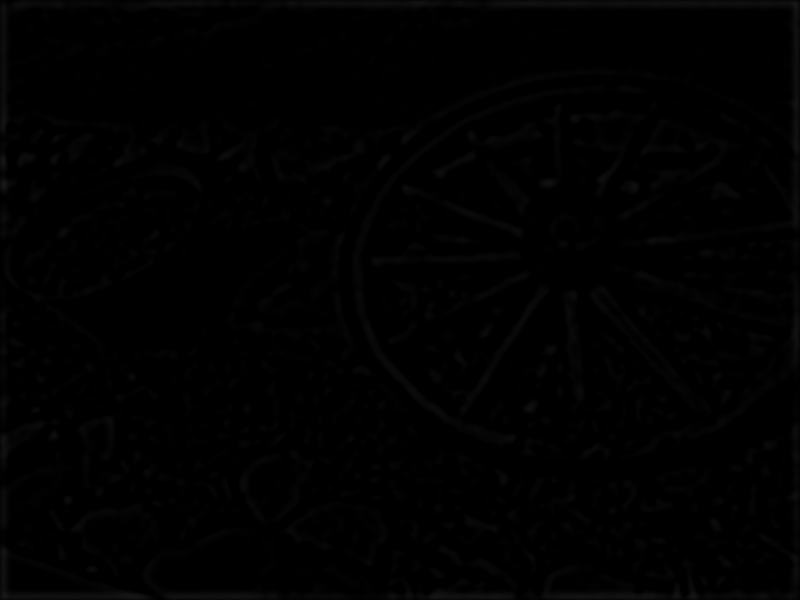

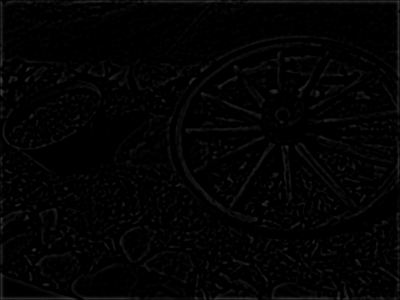

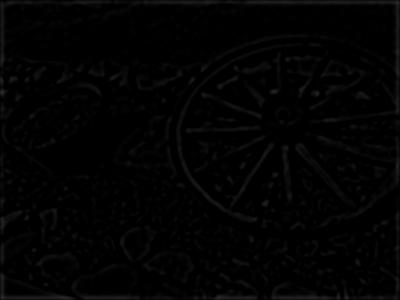

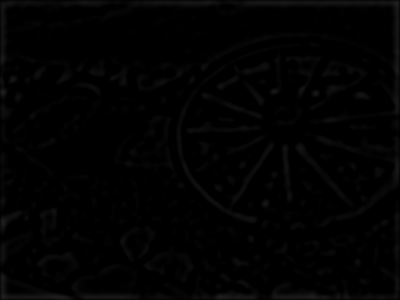

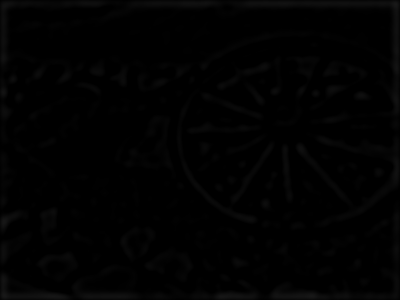

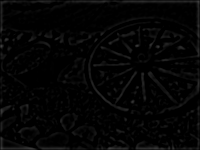

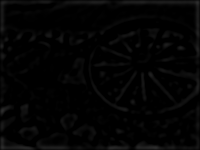

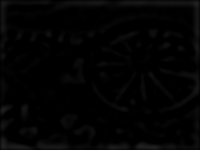

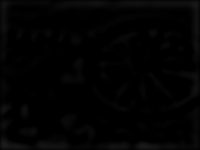

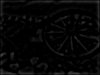

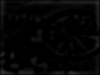

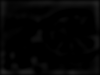

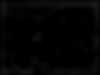

In [11]:
def difference_of_gaussian(img_in, sigma, octave, level, k, scale_space_in = None):
  if scale_space_in != None:
    scale_space = scale_space_in
  else:
    scale_space = sift_scale_space(img_in, sigma, octave, level, k)
  DoG = []
  for img_stack in scale_space:
    DoG.append([img_stack[i] - img_stack[i+1] for i in range(level - 1)])
  
  return DoG

def test_DoG():
  DoG = difference_of_gaussian(img_grayscale, 1.6, 4, 5, np.sqrt(2), scale_space_in = s_scale_space)
  for img_stack in DoG:
    for img in img_stack:
      cv2_imshow(img)
  return DoG

sift_DoG = test_DoG()

### 3. Finding keypoints

In [12]:
def non_maximal_suppression(windows):
  for i in range(3):
    for row in range(3):
      for col in range(3):
        if i == 1 and row == 1 and col == 1:
          continue
        if windows[i][row,col] > windows[1][1, 1]:
        # if abs(windows[i][row,col]) > abs(windows[1][1, 1]):
          return False
  return True

def test_maximal_suppression():
  w1 = np.array([[1,2,1], [1,3,1], [1,2,1]])
  w2 = np.array([[1,1,1], [1,5,1], [1,1,1]])
  w3 = np.array([[1,1,1], [1,4,1], [1,1,1]])
  windows = [w1, w2, w3]
  np.testing.assert_equal(non_maximal_suppression(windows), True)

  w1 = np.array([[1,2,1], [1,7,3], [1,2,1]])
  w2 = np.array([[1,1,1], [1,6,5], [1,1,1]])
  w3 = np.array([[1,1,1], [1,4,5], [1,1,1]])
  windows = [w1, w2, w3]
  np.testing.assert_equal(non_maximal_suppression(windows), False)

  w1 = np.array([[1,2,1], [1,3,3], [1,2,1]])
  w2 = np.array([[1,1,1], [1,6,5], [1,1,1]])
  w3 = np.array([[1,1,1], [1,4,2], [7,1,1]])
  windows = [w1, w2, w3]
  np.testing.assert_equal(non_maximal_suppression(windows), False)

test_maximal_suppression()

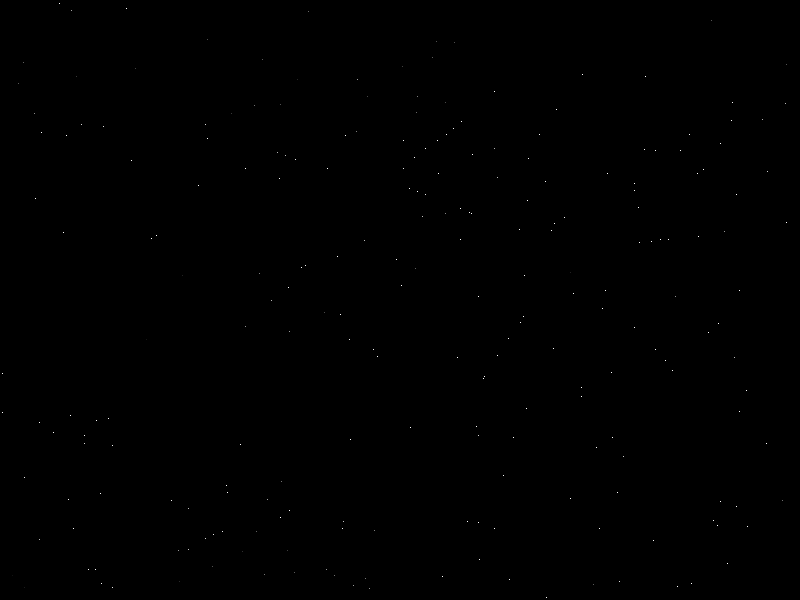

Number of key points: 233



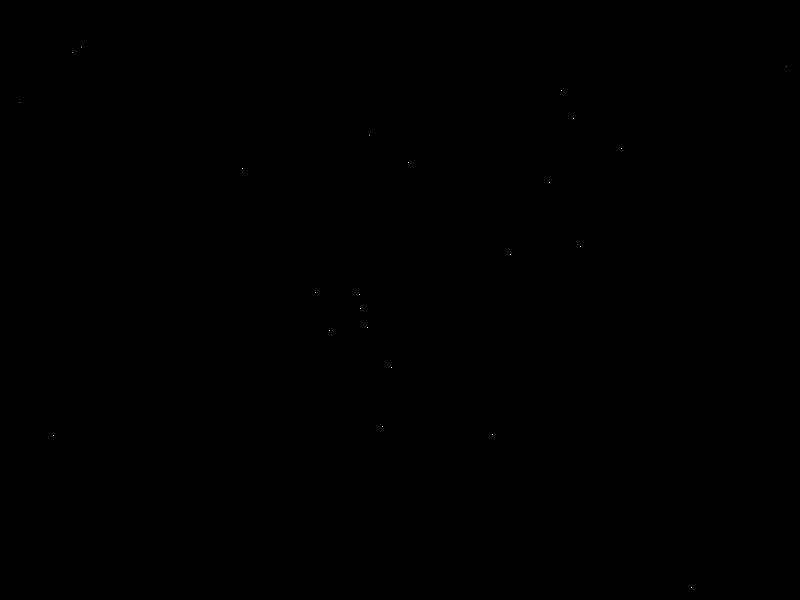

Number of key points: 23



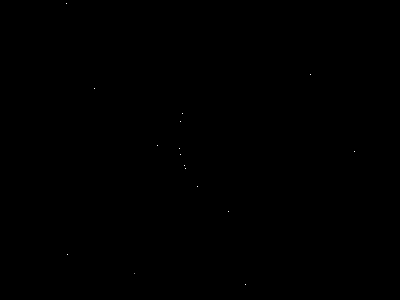

Number of key points: 16



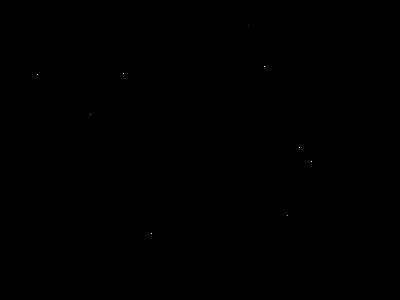

Number of key points: 9



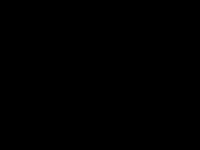

Number of key points: 0



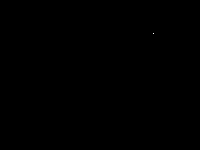

Number of key points: 1



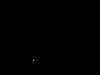

Number of key points: 1



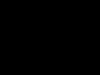

Number of key points: 0



In [13]:
def locate_maxima(img_in, DoG_in = None):
  if DoG_in != None:
    DoG = DoG_in
  else:
    DoG = difference_of_gaussian(img_in, 1.6, 4, 5, np.sqrt(2))
  result = []

  for img_stack in DoG:
    output_stack = []

    for i in range(1, len(img_stack) - 1):
      interest_points = np.zeros((img_stack[i].shape))

      for row in range(1, img_stack[0].shape[0] - 1):
        for col in range(1, img_stack[0].shape[1] - 1):
          prev_window = img_stack[i-1][row-1:row+2, col-1:col+2]
          curr_window = img_stack[i][row-1:row+2, col-1:col+2]
          next_window = img_stack[i+1][row-1:row+2, col-1:col+2]

          maxima = non_maximal_suppression([prev_window, curr_window, next_window])
          if (maxima):
            interest_points[row,col] = abs(img_stack[i][row,col])

      output_stack.append(interest_points)
    result.append(output_stack)
  
  return result

def test_locate_maxima():
  result = locate_maxima(img_grayscale, DoG_in = sift_DoG)
  for img_stack in result:
    for img in img_stack:
      cv2_imshow(img * 30)
      count = sum([1 for row in img for col in row if col != 0])

      print("Number of key points: " + str(count) + "\n")
  return result

key_point_candidate = test_locate_maxima()

### 4. Getting rid of low contrast keypoints

In [14]:
def copy_scale_space(scale_space):
  result = []
  for img_stack in scale_space:
    copy_stack = []
    for img in img_stack:
      copy_stack.append(img.copy())
    result.append(copy_stack)
  
  return result

def test_copy_scale_space():
  result = copy_scale_space(key_point_candidate)
  # test copied scale space are same
  np.testing.assert_equal(result, key_point_candidate)
  # test change in copied scale space do not affect original
  result[0][0][0, 0] = -1
  assert result[0][0][0,0] != key_point_candidate[0][0][0,0]

test_copy_scale_space()

Removed key points #: 104
Removed key points #: 16
Removed key points #: 8
Removed key points #: 3
Removed key points #: 0
Removed key points #: 0
Removed key points #: 0
Removed key points #: 0


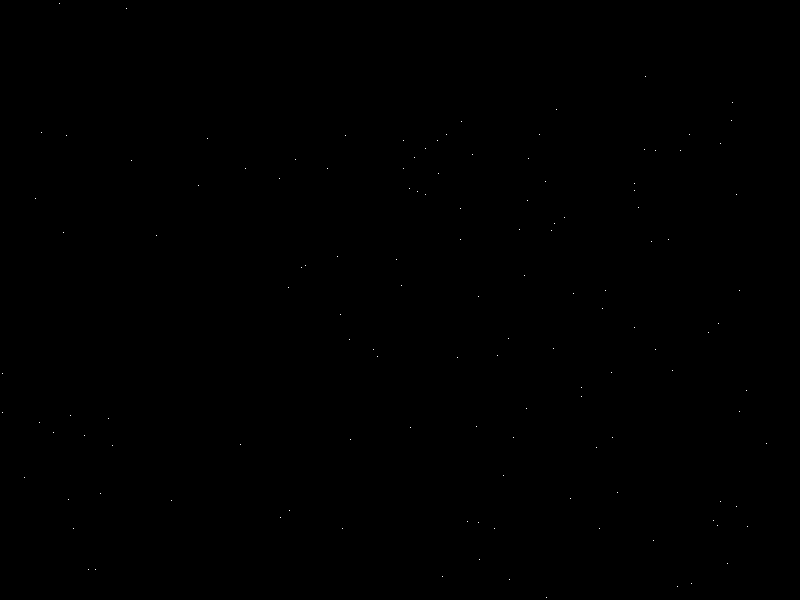

Number of key points: 129



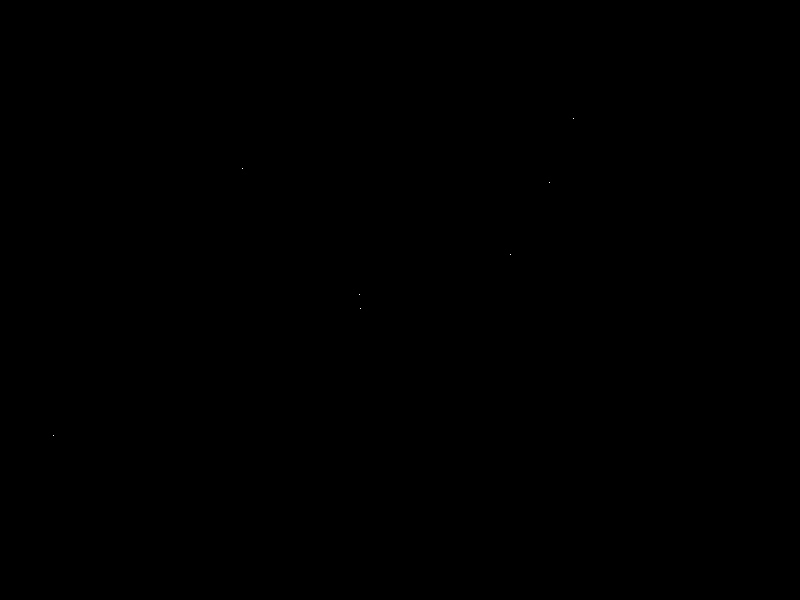

Number of key points: 7



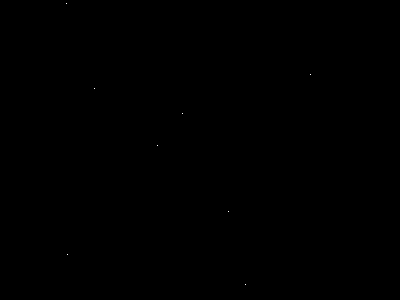

Number of key points: 8



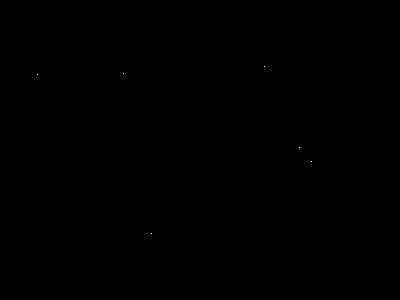

Number of key points: 6



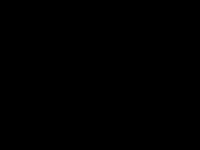

Number of key points: 0



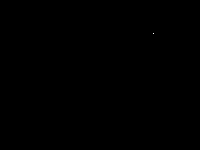

Number of key points: 1



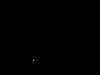

Number of key points: 1



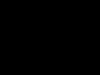

Number of key points: 0



In [15]:
CONTRAST_THRESHOLD = 0.03 * 255
CURVATURE_THRESHOLD = 12.1

def remove_low_contrast(img_in, scale_space, kp_candidate = None, show = False):
  if kp_candidate != None:
    kp_scale_space = kp_candidate
  else:
    kp_scale_space = locate_maxima(img_in)
  
  # make a copy of key point candidates
  new_kp_scale_space = copy_scale_space(kp_scale_space)

  scale_space_index = 0
  for kp_img_stack in new_kp_scale_space:
    
    img_stack_index = 1
    for kp_img in kp_img_stack:
      removed = 0

      for row in range(1, kp_img.shape[0] - 1):
        for col in range(1, kp_img.shape[1] - 1):
          # remove low constrast
          if (kp_img[row,col] != 0 and kp_img[row,col] < CONTRAST_THRESHOLD):
            kp_img[row,col] = 0
            removed += 1
            continue
          
          # remove edge
          img = scale_space[scale_space_index][img_stack_index]
          dxx = img[row,col-1] + img[row,col+1] - 2 * img[row,col]
          dyy = img[row-1,col] + img[row+1,col] - 2 * img[row,col]
          dxy = (img[row-1,col-1] + img[row+1,col+1] -
                 img[row-1,col+1] - img[row+1,col-1]) / 4
          
          trH = dxx + dyy
          detH = dxx * dyy - dxy**2
          curve_ratio = trH**2 / detH
          if (kp_img[row,col] != 0 and (detH < 0 or curve_ratio > CURVATURE_THRESHOLD)):
            kp_img[row,col] = 0
            removed += 1

      img_stack_index += 1
      if show:
        print("Removed key points #: " + str(removed))

    scale_space_index += 1


  return new_kp_scale_space

def test_remove_low_contrast():
  result = remove_low_contrast(img_grayscale, s_scale_space, kp_candidate = key_point_candidate, show = True)
  for img_stack in result:
    for img in img_stack:
      cv2_imshow(img * 30)
      count = sum([1 for row in img for col in row if col != 0])

      print("Number of key points: " + str(count) + "\n")
  return result

kp_scale_space = test_remove_low_contrast()

### 5. Keypoint orientations

In [16]:
def get_scale(octave_index, level_index, sigma = 1.6, k = np.sqrt(2)):
  scale = sigma * (k ** (level_index + 1)) * (2 ** octave_index)
  return scale
    
def test_get_scale():
  for octave in range(4):
    for level in range(2):
      print(get_scale(octave, level))


test_get_scale() 

2.2627416997969525
3.200000000000001
4.525483399593905
6.400000000000002
9.05096679918781
12.800000000000004
18.10193359837562
25.60000000000001


In [17]:
class SiftKeyPoint:
  def __init__(self, x, y, scale, orientation):
    self.x = x
    self.y = y
    self.scale = scale
    self.orientation = orientation

In [18]:
SCALE_FACTOR = 1.5 # Lowe use this scale factor in his paper

def create_sift_keypoint(img, x, y, octave, level, bin_count=36):
  sift_keypoints = []
  histogram = [0 for i in range(bin_count)]
  sigma = get_scale(octave, level)
  radius = sigma * SCALE_FACTOR / 2

  for row in range(round(y-radius), round(y+radius)):
    for col in range(round(x-radius), round(x+radius)):
      if row < 1 or row >= img.shape[0] - 1 or col < 1 or col >= img.shape[1] - 1:
        continue
      
      dx = img[row,col+1] - img[row,col-1]
      dy = img[row+1,col] - img[row-1,col]
      magnitude = np.sqrt(dx**2 + dy**2)
      theta = np.rad2deg(np.arctan2(dy, dx))
      weight = np.exp((-0.5 / sigma**2) * ((row-y)**2 + (col-x)**2))
      histogram_index = int(round(theta * bin_count / 360.))
      histogram[histogram_index % bin_count] += weight * magnitude

  peak = max(histogram)
  #peak_index = histogram.index(peak)
  #histogram = np.roll(histogram, -peak_index)
  for bin in range(len(histogram)):
    if histogram[bin] >= peak * 0.8:
      scale = 2 ** (octave - 1)
      posX = int(round(x * scale))
      posY = int(round(y * scale))
      sift_keypoints.append(SiftKeyPoint(posX, posY, sigma, bin * bin_count/360))

  return sift_keypoints

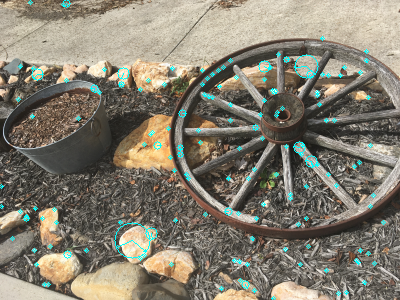

In [31]:
def keypoints_orientation(kp_scale_space, scale_space):
  sift_keypoints = []

  scale_space_index = 0
  for octave in range(len(kp_scale_space)):

    img_stack_index = 1
    for level in range(len(kp_scale_space[octave])):
      kp_img = kp_scale_space[octave][level]
      
      for row in range(kp_img.shape[0]):
        for col in range(kp_img.shape[1]):
          if kp_img[row,col] != 0:
            img = scale_space[scale_space_index][img_stack_index]
            sift_keypoints += create_sift_keypoint(img, col, row, octave, level)
      
      img_stack_index += 1
    scale_space_index += 1

  return sift_keypoints

def test_keypoints_orientation():
  sift_keypoints = keypoints_orientation(kp_scale_space, s_scale_space)

  img_copy = img_color.copy()
  for point in sift_keypoints:
    endpoint = (int(point.scale * np.cos(point.orientation)) + point.x, 
                int(point.scale * np.sin(point.orientation)) + point.y)
    cv2.arrowedLine(img_copy, (point.x,point.y), endpoint, (255,255,0), 1)
    cv2.circle(img_copy, (point.x,point.y), int(point.scale), (255,255,0), 1)
  cv2_imshow(img_copy)

  return sift_keypoints

sift_keypoints = test_keypoints_orientation()

### 6. Putting it togather

In [32]:
def sift_detector(img_color):
  img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
  img_out = img_color.copy()

sift_detector(img_color)

def test_sift_detector():
  key_points = sift_detector(img_color)

### SIFT descriptor

In [54]:
SIFT_WINDOW_SIZE = 16
SIFT_BIN_NUM = 8

def sift_compute_subregion(img, window_center, keypoint_center, orientation):
  histogram = [0 for i in range(SIFT_BIN_NUM)]
  w_x, w_y = window_center
  kp_x, kp_y = keypoint_center

  for row in range(round(w_y-2), round(w_y+2)):
    for col in range(round(w_x-2), round(w_x+2)):
      if row < 1 or row >= img.shape[0] - 1 or col < 1 or col >= img.shape[1] - 1:
        continue
      
      dx = img[row,col+1] - img[row,col-1]
      dy = img[row+1,col] - img[row-1,col]
      magnitude = np.sqrt(dx**2 + dy**2)
      theta = np.rad2deg(np.arctan2(dy, dx))
      sigma = SIFT_WINDOW_SIZE * 0.5
      weight = np.exp((-0.5 / sigma**2) * ((row-kp_y)**2 + (col-kp_x)**2))

      theta_adjusted = theta - orientation
      histogram_index = int(round(theta_adjusted * SIFT_BIN_NUM / 360.))
      histogram[histogram_index % SIFT_BIN_NUM] += weight * magnitude

  return histogram


In [34]:
class SiftFeature:
  def __init__(self, x, y, descriptor):
    self.x = x
    self.y = y
    self.descriptor = descriptor

In [35]:
def scale_img(sigma):
  for octave in range(4):
    for level in range(4):
      if np.isclose(get_scale(octave, level - 1), sigma):
        return octave, level - 1

  raise ValueError("Invalid scale (sigma) for the key point")

def test_scale_img():
  sigmas = []
  for octave in range(4):
    for level in range(3):
      sigmas.append(get_scale(octave, level))

  for sigma in sigmas:
    print(scale_img(sigma))

test_scale_img()

(0, 0)
(0, 1)
(0, 2)
(0, 2)
(1, 1)
(1, 2)
(1, 2)
(2, 1)
(2, 2)
(2, 2)
(3, 1)
(3, 2)


In [55]:
def sift_descriptor(keypoints, scale_space):
  sift_features = []
  count = 0
  for point in keypoints:
    histogram = []
    octave, level = scale_img(point.scale)
    img = scale_space[octave][level]
    scale = 2 ** -(octave - 1)
    posX = int(round(point.x * scale))
    posY = int(round(point.y * scale))

    for offsetY in range(-4, 5, 2):
      for offsetX in range(-4, 5, 2):
        if offsetY == 0 or offsetX == 0:
          continue

        histogram += sift_compute_subregion(img, (posX + offsetX, posY + offsetY), (posX, posY), point.orientation)


    hist_norm = [i / sum(histogram) for i in histogram]

    sift_features.append(SiftFeature(point.x, point.y, hist_norm))
    count += 1

  return sift_features
    
def test_sift_descriptor():
  sift_features = sift_descriptor(sift_keypoints, s_scale_space)

test_sift_descriptor()

222


References:  
https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf  
https://aishack.in/tutorials/sift-scale-invariant-feature-transform-introduction/  
https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html  


### Nearest Neighbor Matching

In [ ]:
import opencv